In [ ]:
# Original: https://github.com/sainathadapa/attention-primer-pytorch/tree/master/1_counting-letters

# The task is to write a count of the number of elements of a fixed-size sequence
# consisting of characters A, B, C

# [A, B, B, C] ->  { A:1, B:2, C:1 }
# [A, B, B, A] ->  { A:2, B:2, C:0 }
#
# S = 4 - long incoming sequence
# L = 3 - long outgoing, equal to dictionary size
# E_x = 3 = len(vocabular) = 3 - embedding size for a letter is equal to the size of the dictionary
# E_y = 4 = S + 1 - The embedding size for the counter is equal to <sequence length + 1>
#
# Sample of data:
# X.shape = [S, E_x]:
#  A -> 0 -> [1, 0, 0]
#  B -> 1 -> [0, 1, 0]
#  B -> 1 -> [0, 1, 0]
#  C -> 2 -> [0, 0, 1]
#
# Y.shape = [L, E_y]
#  A:1 -> [0, 1, 0, 0, 0]
#  B:2 -> [0, 0, 1, 0, 0]
#  C:1 -> [0, 1, 0, 0, 0]

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import random

## SEED

In [ ]:
torch.use_deterministic_algorithms(True)
SEED = 1 # try to 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## CONSTANTS

In [ ]:
#vocabular = ["A", "B", "C"]
vocabular = ["A", "B", "C"]
query_vocabular = ["COUNTER_A", "COUNTER_B", "COUNTER_C"]

S = 10
E_x = len(vocabular)

L = len(query_vocabular)
E_y = S + 1

E_q = len(query_vocabular)

E_hidden = 64
SQRT_E_k = np.sqrt(E_hidden)

BATCH_SIZE = 100

## DATA

In [ ]:
id_to_char = { i: symbol for i, symbol in enumerate(vocabular)}
char_to_id = { symbol: i for i, symbol in id_to_char.items() }

id_to_query = { i: q for i, q in enumerate(query_vocabular)}
query_to_id = { q: i for i, q in id_to_query.items() }

def get_seq():
  seq = np.random.randint(low=0, high=len(vocabular), size=S)
  return seq

def str_seq(sequence):
  return [id_to_char[i] for i in sequence]

def get_counter(sequence):
  counter = [0 for i in range(L)]
  for seq_id in sequence:
    if id_to_char[seq_id] != "-":
      counter[seq_id] += 1

  return np.array(counter)

def str_counter(counter):
  out = { name:0 for name in query_vocabular }
  for counter_id, counter_value in enumerate(counter):
    out[id_to_query[counter_id]] = counter_value
  return out

In [ ]:
seq = get_seq()
counter = get_counter(seq)

print("seq:", seq)
print("counter:", counter)
print("====or====")
print("seq:", str_seq(seq))
print("counter:", str_counter(counter))

seq: [2 0 2 1 0 1 2 2 0 1]
counter: [3 3 4]
====or====
seq: ['C', 'A', 'C', 'B', 'A', 'B', 'C', 'C', 'A', 'B']
counter: {'COUNTER_A': 3, 'COUNTER_B': 3, 'COUNTER_C': 4}


## DATASET

In [ ]:
class SequenceCounterDataset(torch.utils.data.Dataset):
  def __init__(self, N):
      self.N = N

  def __getitem__(self, index):
    x = get_seq()
    y = get_counter(x)

    x = torch.Tensor(x).long()
    y = torch.Tensor(y).long()

    return x, y

  def __len__(self):
    return self.N

## MODEL_V1

In [ ]:
# Q = X * W_q
# K = X * W_k
# V = X * W_v
# Attention = softmax(Q*K_T/sqrt(E_k)) * V

class AttentionModel_V1(nn.Module):
  def __init__(self):
    super(AttentionModel_V1, self).__init__()
    self.W_q = nn.Parameter(torch.zeros((E_q, E_hidden))) # [E_q, E_hidden]
    torch.nn.init.xavier_uniform_(self.W_q)

    self.W_k = nn.Parameter(torch.zeros((E_x, E_hidden))) # [E_x, E_hidden]
    torch.nn.init.xavier_uniform_(self.W_k)

    self.W_v = nn.Parameter(torch.zeros((E_x, E_hidden))) # [E_x, E_hidden]
    torch.nn.init.xavier_uniform_(self.W_v)

    self.layer_norm = nn.LayerNorm(E_hidden)
    self.final_dense = nn.Linear(E_hidden, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = torch.nn.functional.one_hot(x, num_classes=E_x).float() # [N, S, E_x]
    q = torch.nn.functional.one_hot(q, num_classes=E_q).float() # [N, L, E_q]

    Q = torch.matmul(q, self.W_q) # [N, L, E_hidden]
    K = torch.matmul(x, self.W_k) # [N, S, E_hidden]
    V = torch.matmul(x, self.W_k) # [N, S, E_hidden]

    attention_weights = torch.softmax(
        torch.bmm(Q, K.transpose(2, 1)) / SQRT_E_k,
        dim=2
    ) # [N, L, S]
    output = torch.bmm(attention_weights, V) # [N, L, E_hidden]

    output = output + Q
    output = F.relu(output)
    #output = self.layer_norm(output) # [N, L, E_hidden]
    output = self.final_dense(output) # [N, L, E_y]

    return output, attention_weights

## MODEL_V2
[original code](https://github.com/sainathadapa/attention-primer-pytorch/blob/master/1_counting-letters/main.py)

In [ ]:
# Q = X * W_q
# K = X * W_k
# V = X * W_v
# Attention = softmax(Q*K_T/sqrt(E_k)) * V

class AttentionModel_V2(nn.Module):
  def __init__(self):
    super(AttentionModel_V2, self).__init__()
    self.W_q = nn.Parameter(torch.zeros((E_q, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_q)

    self.W_kv = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_kv)

    self.layer_norm = nn.LayerNorm(E_hidden)
    self.final_dense = nn.Linear(E_hidden, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = torch.nn.functional.one_hot(x, num_classes=E_x).float() # [N, S, E_x]
    q = torch.nn.functional.one_hot(q, num_classes=E_q).float() # [N, L, E_q]

    Q = torch.matmul(q, self.W_q)  # [N, L, E_hidden]
    K = torch.matmul(x, self.W_kv) # [N, S, E_hidden]
    V = torch.matmul(x, self.W_kv) # [N, S, E_hidden]

    attention_weights = torch.softmax(
        torch.bmm(Q, K.transpose(2, 1)) / SQRT_E_k,
        dim=2
    ) # [N, L, S]

    output = torch.bmm(attention_weights, V) # [N, L, E_hidden]

    output = output + Q

    output = self.layer_norm(output) # [N, L, E_hidden]
    output = self.final_dense(output) # [N, L, E_y]

    return output, attention_weights

## MODEL_V3

In [ ]:
# Q = X * W_q
# K = X * W_k
# V = X * W_v
# Attention = softmax(Q*K_T/sqrt(E_k)) * V


#https://github.com/kyegomez/AttentionIsOFFByOne
# Define the softmax_one function with added one in the denominator , which helps to reduce
#the negative impact impact of tiny values in the softmax function and improves numerical stability
def softmax_one(x, dim=None, _stacklevel=3, dtype=None):
    #subtract the max for stability
    x = x - x.max(dim=dim, keepdim=True).values
    #compute exponentials
    exp_x = torch.exp(x)
    #compute softmax values and add on in the denominator
    return exp_x / (1 + exp_x.sum(dim=dim, keepdim=True))

class AttentionModel_V3(nn.Module):
  def __init__(self):
    super(AttentionModel_V3, self).__init__()

    self.W_q = nn.Parameter(torch.zeros((E_q, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_q)

    self.W_k = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_k)

    self.W_v = nn.Parameter(torch.zeros((E_x, E_hidden)))
    torch.nn.init.xavier_uniform_(self.W_v)

    self.layer_norm_1 = nn.LayerNorm(E_hidden)

    self.linear_layer_1 = nn.Linear(E_hidden, 32)
    self.layer_norm_2 = nn.LayerNorm(32)

    self.final_dense = nn.Linear(32, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = torch.nn.functional.one_hot(x, num_classes=E_x).float() # [N, S, E_x]
    q = torch.nn.functional.one_hot(q, num_classes=E_q).float() # [N, L, E_q]

    Q = torch.matmul(q, self.W_q)  # [N, L, E_hidden]
    K = torch.matmul(x, self.W_k) # [N, S, E_hidden]
    V = torch.matmul(x, self.W_v) # [N, S, E_hidden]

    attention_weights = softmax_one(
        torch.bmm(Q, K.transpose(2, 1)) / SQRT_E_k,
        dim=2
    ) # [N, L, S]

    output = torch.bmm(attention_weights, V) # [N, L, E_hidden]

    output = self.layer_norm_1(output) # [N, L, E_hidden]

    output = output + Q
    output = self.linear_layer_1(output)
    output = F.relu(output)
    output = self.layer_norm_2(output)

    output = self.final_dense(output) # [N, L, E_y]

    return output, attention_weights

## NAIVE MODEL

In [ ]:
# Q = X * W_q
# K = X * W_k
# V = X * W_v
# Attention = softmax(Q*K_T/sqrt(E_k)) * V

class NaiveModel(nn.Module):
  def __init__(self):
    super(NaiveModel, self).__init__()
    self.linear_1 = nn.Linear(E_x, E_hidden)
    self.linear_2 = nn.Linear(S, L)

    self.linear_3 = nn.Linear(E_hidden, E_hidden)

    self.linear_4 = nn.Linear(L, L)

    self.layer_norm = nn.LayerNorm(E_hidden)
    self.final_dense = nn.Linear(E_hidden, E_y)

  def forward(
      self,
      x, # [N, S]
      q  # [N, L]
  ):
    x = torch.nn.functional.one_hot(x, num_classes=E_x).float() # [N, S, E_x]

    x = self.linear_1(x)
    x = F.relu(x)

    x = self.linear_2(x.transpose(2, 1)).transpose(2, 1)
    x = F.relu(x)

    x = self.linear_3(x)
    x = F.relu(x)

    x = self.linear_4(x.transpose(2, 1)).transpose(2, 1)
    x = F.relu(x)

    x = self.layer_norm(x)
    x = self.final_dense(x)

    return x, None

## TRAIN LOOP

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

train_loader = torch.utils.data.DataLoader(
    SequenceCounterDataset(2000 * 100),
    shuffle=True,
    sampler=None,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
)

model = AttentionModel_V1()
#model = NaiveModel()

q = [query_to_id[it] for it in ["COUNTER_A", "COUNTER_B", "COUNTER_C"]]
q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]
q = q.repeat((BATCH_SIZE, 1)) # [N, L]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

step_i = 300

i = 0
mean_loss = 0
acc_grad = None
while True:
  # x, y = next(iter(train_loader))
  # while True:
  for x, y in train_loader:
    model.train(True)
    optimizer.zero_grad()

    out, _ = model(x, q)

    loss = F.cross_entropy(
        out.view(-1, E_y), # [N, L, E_y] -> [N * L, E_y]
        y.view(-1) # [N, L] -> [N * L]
    )
    loss.backward()

    optimizer.step()
    i += 1

    mean_loss += loss.item()

    #grad = None
    grad = model.W_q.grad
    grad_name = "W_q"
    #grad = model.linear_layer_1.weight.grad

    if acc_grad is None:
      acc_grad = grad
    else:
      acc_grad += grad

    if i % step_i == 0:
      mean_loss = np.round(mean_loss / step_i, 3)

      if acc_grad is not None:
        acc_grad = acc_grad / step_i

        mean_grad = torch.mean(acc_grad)
        std_grad = torch.std(acc_grad)
        mean_abs_grad = np.round(torch.mean(torch.abs(acc_grad)).item() * 1e4, 4)
      else:
        mean_grad = None
        std_grad = None
        mean_abs_grad = None

      #print(f"{i}) loss: {mean_loss}")
      print(f"{i}) loss: {mean_loss};  {grad_name}: {mean_abs_grad}")

      acc_grad = None
      mean_loss = 0
  #   break
  # break

300) loss: 0.988;  W_q: 9.112
600) loss: 0.273;  W_q: 6.6401
900) loss: 0.133;  W_q: 4.3469
1200) loss: 0.085;  W_q: 3.0323
1500) loss: 0.06;  W_q: 2.1626
1800) loss: 0.042;  W_q: 1.621


KeyboardInterrupt: ignored

## Check result

In [ ]:
q = [query_to_id[it] for it in ["COUNTER_A", "COUNTER_B", "COUNTER_C"]]
#q = [query_to_id[it] for it in ["COUNTER_C", "COUNTER_B", "COUNTER_A"]]


seq = get_seq()
#seq = ['A', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B']
#seq = ['A', 'B', 'A', 'B', 'B', '-', '-', '-', '-', '-']
#seq = [char_to_id[it] for it in seq]

counter = get_counter(seq)
print("seq:", str_seq(seq))
print("counter:", str_counter(counter))


q = torch.Tensor(q).long() # [L]
q = q.unsqueeze(dim=0) # [1, L]

model.train(False)
model.eval()

with torch.no_grad():
  out, attention_weights = model(
      torch.Tensor(seq).long().unsqueeze(0),
      q
      #torch.Tensor(seq).long().unsqueeze(0),
  )
print("======================")
print("counter:", counter)
print("predicted:", out.argmax(dim=2))

seq: ['C', 'B', 'C', 'B', 'A', 'B', 'B', 'B', 'C', 'A']
counter: {'COUNTER_A': 2, 'COUNTER_B': 5, 'COUNTER_C': 3}
counter: [2 5 3]
predicted: tensor([[2, 5, 3]])


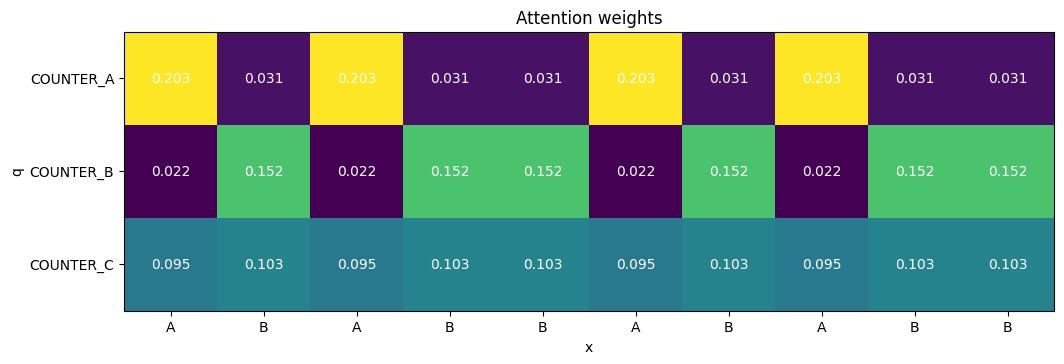

In [ ]:
import matplotlib.colors as colors

cell_size = 4

attention_weights_numpy = attention_weights.numpy().squeeze()
q_numpy = q.numpy().squeeze()

attention_weights_numpy = attention_weights.detach().cpu().numpy().squeeze()
if len(attention_weights_numpy.shape) < 2:
  attention_weights_numpy = np.expand_dims(attention_weights_numpy, 0)

q_numpy = q.numpy().squeeze()
if len(q_numpy.shape) < 1:
  q_numpy = np.expand_dims(q_numpy, 0)

count_rows = attention_weights_numpy.shape[0]
count_columns = attention_weights_numpy.shape[1]


plt.figure(figsize = (cell_size * count_rows, count_columns * cell_size))
plt.imshow(attention_weights_numpy, extent=[0, count_columns, count_rows, 0])

for i in range(count_rows):
  for j in range(count_columns):
    e = attention_weights_numpy[i][j]
    e = np.round(e, 3)
    plt.annotate(str(e), xy=(j+0.5, i+0.5), ha='center', va='center', color='white')

plt.title("Attention weights")
plt.xlabel("x")
plt.ylabel("q")
plt.xticks(
    ticks=np.arange(0, count_columns) + 0.5,
    labels=str_seq(seq)
)
plt.yticks(
    ticks=np.arange(0, count_rows) + 0.5,
    labels=[id_to_query[id] for id in q_numpy]
)

plt.show()

In [ ]:
attention_weights_numpy[2, :].sum()

0.9066982